In [ ]:
# Execute this cell to install dependencies
%pip install sf-hamilton[visualization]

# Lineage Code Snippets [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dagworks-inc/hamilton/blob/main/examples/lineage/lineage_snippets.ipynb) [![GitHub badge](https://img.shields.io/badge/github-view_source-2b3137?logo=github)](https://github.com/dagworks-inc/hamilton/blob/main/examples/lineage/lineage_snippets.ipynb)

Here is a notebook that shows you code snippets that you can use for lineage purposes. It uses the Hamilton code operating over the Titanic dataset for demonstration purposes.

In [1]:
from hamilton import base
from hamilton import driver

# modules that house the Hamilton code we build the lineage/DAG from.
import data_loading
import features
import model_pipeline
import sets


In [2]:
# Determine configuration for creating the DAG.
config = {}  # This example has no configuration that changes the DAG/lineage shape.
# instantiate the driver
adapter = base.DefaultAdapter()
dr = driver.Driver(config, data_loading, features, sets, model_pipeline, adapter=adapter)


Note: Hamilton collects completely anonymous data about usage. This will help us improve Hamilton over time. See https://github.com/dagworks-inc/hamilton#usage-analytics--data-privacy for details.


# Display everything
Useful for a global overview.

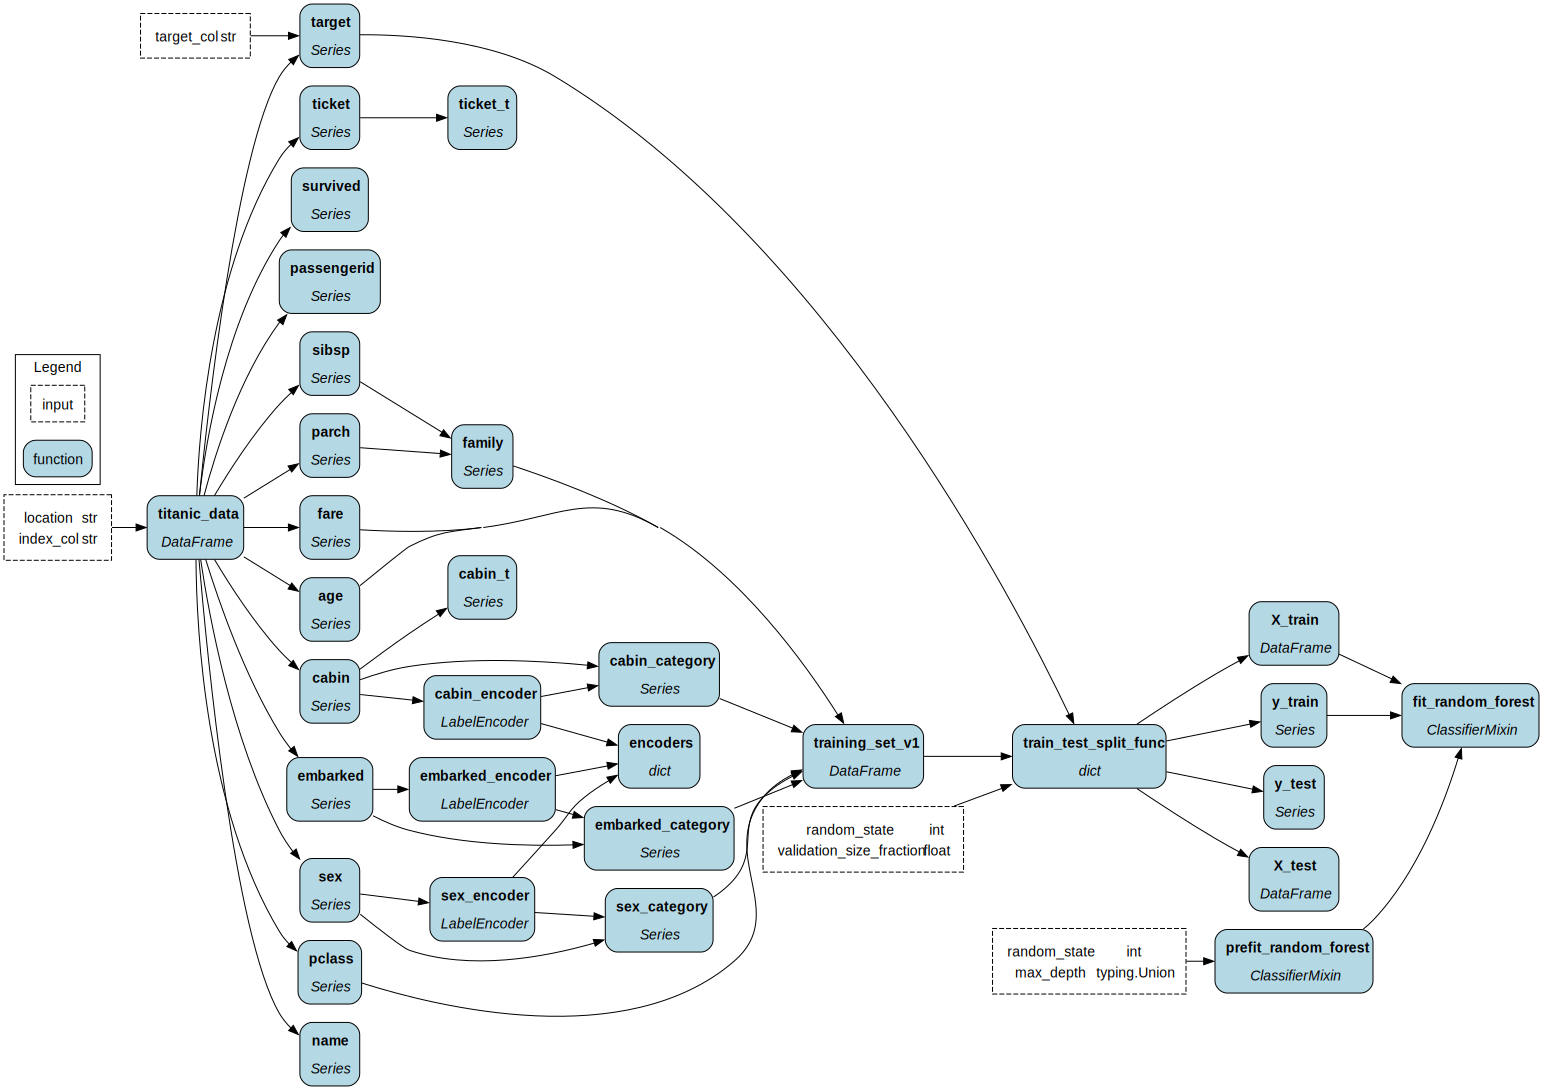

In [3]:
dr.display_all_functions()  # pass in a path if you want to save the image.

# Visualize how something is built: what sequence of operations produced this data/model?
E.g. how do the feature encoders get computed and what flows into them?

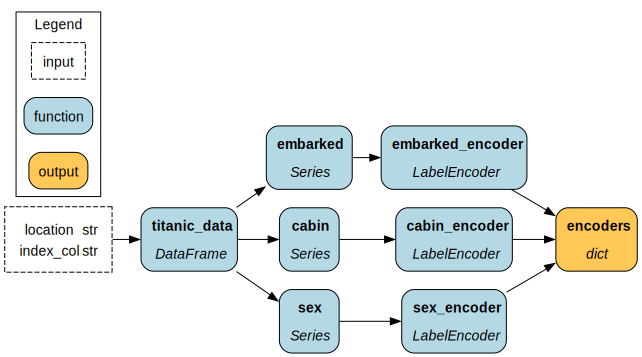

In [4]:
inputs = {
    "location": "data/train.csv",
    "index_col": "passengerid",
    "target_col": "survived",
    "random_state": 42,
    "max_depth": None,
    "validation_size_fraction": 0.33,
}
dr.visualize_execution(
    [features.encoders], None, {}, inputs=inputs  # pass in a path if you want to save the image.
)

# Understand the upstream lineage of a particular output: Whose/What data sources led to this artifact/model?
E.g. There is something funky with the Random Forest model and we want to double-check
for the current production model, what the data sources are and who owns them,
so we can go ping them

In [5]:
upstream_nodes = dr.what_is_upstream_of("fit_random_forest")
teams = []
# iterate through
for node in upstream_nodes:
    # filter to nodes that we're interested in getting information about
    if node.tags.get("source"):
        # append for output
        teams.append({
            "team": node.tags.get("owner"),
            "function": node.name,
            "source": node.tags.get("source"),
        })
teams

[{'team': 'data-engineering',
  'function': 'titanic_data',
  'source': 'prod.titantic'}]

# Understand the downstream lineage of a particular output: Who/What is downstream of this transform?
E.g. Say we're on data engineering and want to change the source data. How could we determine
what the artifacts that use this data are and who owns them?

In [6]:
downstream_nodes = dr.what_is_downstream_of("titanic_data")
artifacts = []
for node in downstream_nodes:
    # if it's an artifact function
    if node.tags.get("artifact"):
        # pull out the information we want
        artifacts.append({
            "team": node.tags.get("owner"),
            "function": node.name,
            "artifact": node.tags.get("artifact"),
        })
artifacts

[{'team': 'data-science',
  'function': 'fit_random_forest',
  'artifact': 'model'},
 {'team': 'data-science',
  'function': 'training_set_v1',
  'artifact': 'training_set'},
 {'team': 'data-science', 'function': 'encoders', 'artifact': 'encoders'}]

# More advanced queries: What is defined as PII data, and what does it end up in?
E.g. Let's say our compliance team has come to us to understand how we're using PII data,
i.e. what artifacts does it end up in? They want this report every month

In [7]:
pii_nodes = [n for n in dr.list_available_variables()
             if n.tags.get("PII") == "true"]
pii_to_artifacts = {}
# loop through each PII node
for node in pii_nodes:
    pii_to_artifacts[node.name] = []
    # ask what is downstream
    downstream_nodes = dr.what_is_downstream_of(node.name)
    for dwn_node in downstream_nodes:
        # Filter to nodes of interest
        if dwn_node.tags.get("artifact"):
            # pull out information
            pii_to_artifacts[node.name].append({
                "team": dwn_node.tags.get("owner"),
                "function": dwn_node.name,
                "artifact": dwn_node.tags.get("artifact"),
            })
pii_to_artifacts

{'sex': [{'team': 'data-science',
   'function': 'training_set_v1',
   'artifact': 'training_set'},
  {'team': 'data-science',
   'function': 'fit_random_forest',
   'artifact': 'model'},
  {'team': 'data-science', 'function': 'encoders', 'artifact': 'encoders'}],
 'age': [{'team': 'data-science',
   'function': 'training_set_v1',
   'artifact': 'training_set'},
  {'team': 'data-science',
   'function': 'fit_random_forest',
   'artifact': 'model'}]}

# Understanding how two things connect more deeply: What is in between this data source and this model?
E.g. say we're new to the team and want to understand how the data flows from the data source to
the model. We can use the `what_is_the_path_between` function to understand the lineage between two nodes.

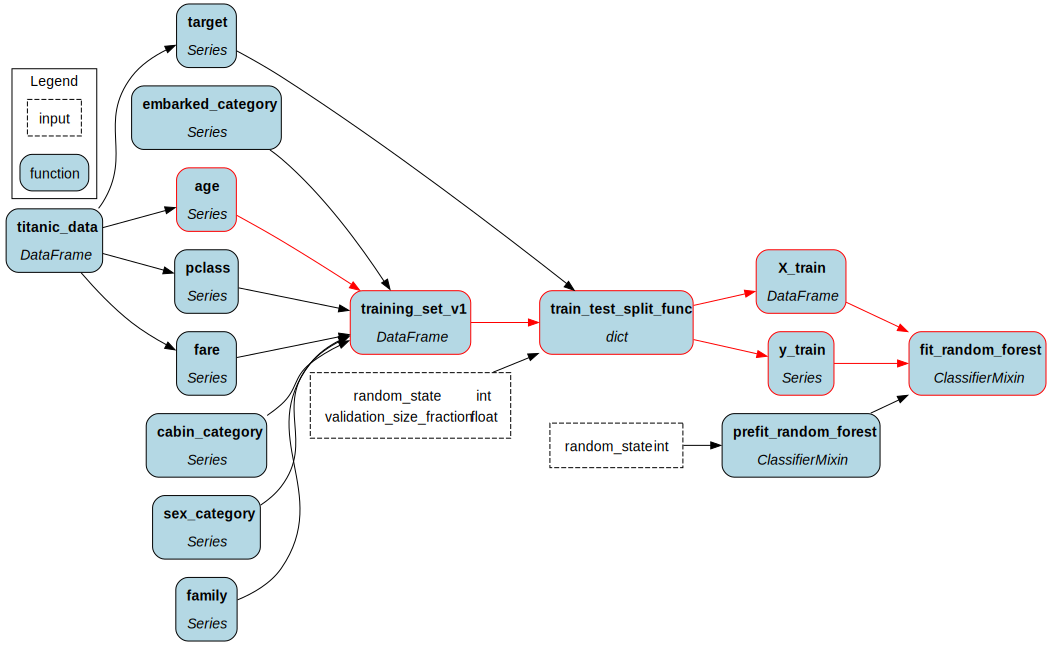

In [14]:
# Visualize a particular path:
dr.visualize_path_between("age", "fit_random_forest")  # pass in a path if you want to save the image.


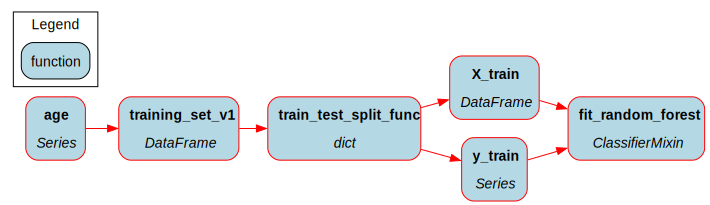

In [9]:
# If we want to just focus on the path we can do:
dr.visualize_path_between("age", "fit_random_forest", strict_path_visualization=True)  # pass in values if you want to save the image.


In [10]:
# to programmatically get the nodes in the path:
nodes_in_path = dr.what_is_the_path_between("age", "fit_random_forest")
nodes_in_path

[Variable(name='train_test_split_func', type=typing.Dict[str, typing.Union[pandas.core.frame.DataFrame, pandas.core.series.Series]], tags={'module': 'model_pipeline'}, is_external_input=False, originating_functions=(<function train_test_split_func at 0x13f043040>,)),
 Variable(name='training_set_v1', type=<class 'pandas.core.frame.DataFrame'>, tags={'module': 'sets', 'owner': 'data-science', 'importance': 'production', 'artifact': 'training_set'}, is_external_input=False, originating_functions=(<function training_set_v1 at 0x13f043280>,)),
 Variable(name='fit_random_forest', type=<class 'sklearn.base.ClassifierMixin'>, tags={'module': 'model_pipeline', 'owner': 'data-science', 'importance': 'production', 'artifact': 'model'}, is_external_input=False, originating_functions=(<function fit_random_forest at 0x13f043160>,)),
 Variable(name='age', type=<class 'pandas.core.series.Series'>, tags={'module': 'data_loading', 'PII': 'true'}, is_external_input=False, originating_functions=(<functio